In [115]:
import random
import csv
import itertools
import time
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev



In [116]:
def lire_fichier(fichier):
    with open(fichier, 'r') as f:
        liste_items = []
        data_section = False
        max_capacity = None
        for ligne in f:
            ligne = ligne.strip()
            if ligne.startswith('MAX_CAPACITY:'):
                max_capacity = int(ligne.split()[1])
            elif ligne.startswith('DATA [id profit weight]:'):
                data_section = True
            elif data_section and ligne:
                parts = ligne.split()
                if len(parts) == 3:
                    idx = int(parts[0])
                    profit = int(parts[1])
                    weight = int(parts[2])
                    liste_items.append((idx, profit, weight))
    return max_capacity, liste_items

In [117]:
def generer_solution_aleatoire(n):
    """Génère aléatoirement un vecteur binaire de taille n."""
    return [random.randint(0, 1) for _ in range(n)]

def calculer_poids_total(liste_items, solution):
    """Calcule la somme des poids des items sélectionnés."""
    return sum(liste_items[i][2] for i in range(len(solution)) if solution[i] == 1)

def calculer_profit_total(liste_items, solution):
    """Calcule le profit total des items sélectionnés."""
    return sum(liste_items[i][1] for i in range(len(solution)) if solution[i] == 1)

def fitness(liste_items, solution, max_capacity):
    """
    Renvoie la fitness d'une solution.
    - Si la capacité est dépassée, on applique une pénalité.
    - Sinon, c'est simplement le profit total.
    """
    poids = calculer_poids_total(liste_items, solution)
    profit = calculer_profit_total(liste_items, solution)
    if poids > max_capacity:
        # Pénalité : on soustrait une partie du dépassement au profit
        return profit - 100 * (poids - max_capacity)
    else:
        return profit

def selection_tournoi(population, fitnesses, k=2):
    """
    Sélection par tournoi :
    - On choisit aléatoirement k individus, on prend le meilleur en termes de fitness.
    - On renvoie l'indice du vainqueur.
    """
    participants = random.sample(range(len(population)), k)
    best_idx = participants[0]
    best_fit = fitnesses[best_idx]
    for idx in participants[1:]:
        if fitnesses[idx] > best_fit:
            best_idx = idx
            best_fit = fitnesses[idx]
    return best_idx

def crossover_1point(parent1, parent2):
    """
    Croisement 1-point : on coupe les gènes en un point choisi aléatoirement
    et on échange les segments.
    """
    n = len(parent1)
    point = random.randint(1, n-1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def mutation_flip(child, prob_mut=0.01):
    """
    Mutation : on parcourt chaque bit,
    et on le flip avec une probabilité prob_mut.
    """
    for i in range(len(child)):
        if random.random() < prob_mut:
            child[i] = 1 - child[i]
    return child

In [118]:
def algogen_knapsack(liste_items, max_capacity,
                     pop_size=50,
                     max_gen=100,
                     pcross=0.8,
                     pmut=0.01,
                     tournament_k=2):
    """
    Algorithme génétique classique pour le Knapsack 0-1.
    :param liste_items: liste de (id, profit, weight)
    :param max_capacity: capacité max du sac
    :param pop_size: taille de la population
    :param max_gen: nombre de générations
    :param pcross: probabilité de crossover
    :param pmut: probabilité de mutation (flip)
    :param tournament_k: taille du tournoi pour la sélection
    :return: (best_solution, best_fitness)
    """

    n = len(liste_items)

    # --- 1) Initialisation de la population ---
    population = [generer_solution_aleatoire(n) for _ in range(pop_size)]
    
    # Calcul des fitness initiaux
    fitnesses = [fitness(liste_items, sol, max_capacity) for sol in population]

    best_global_sol = None
    best_global_fit = float('-inf')

    # Mise à jour du meilleur global initial
    for i, fit in enumerate(fitnesses):
        if fit > best_global_fit:
            best_global_fit = fit
            best_global_sol = population[i][:]

    # --- 2) Boucle génétique principale ---
    for gen in range(max_gen):
        new_population = []

        # Tant qu'on n'a pas une population complète...
        while len(new_population) < pop_size:
            # --- a) Sélection de deux parents par tournoi ---
            idx1 = selection_tournoi(population, fitnesses, tournament_k)
            idx2 = selection_tournoi(population, fitnesses, tournament_k)
            parent1 = population[idx1]
            parent2 = population[idx2]

            # --- b) Crossover (avec probabilité pcross) ---
            if random.random() < pcross:
                child1, child2 = crossover_1point(parent1, parent2)
            else:
                child1, child2 = parent1[:], parent2[:]

            # --- c) Mutation ---
            child1 = mutation_flip(child1, pmut)
            child2 = mutation_flip(child2, pmut)
            
            # On ajoute les enfants à la nouvelle population
            new_population.append(child1)
            if len(new_population) < pop_size:  # évite de dépasser pop_size
                new_population.append(child2)

        # --- d) Remplacement : on remplace l'ancienne pop par la nouvelle ---
        population = new_population
        
        # Recalculer les fitness
        fitnesses = [fitness(liste_items, sol, max_capacity) for sol in population]

        # --- e) Mettre à jour le meilleur global ---
        for i, fit in enumerate(fitnesses):
            if fit > best_global_fit:
                best_global_fit = fit
                best_global_sol = population[i][:]

    return best_global_sol, best_global_fit

In [119]:
# ---------------------------------------------------------------------
if __name__ == '__main__':
    # Exemple : à adapter selon le nom du fichier
    fichier_test = "pi-12-100-1000-001.kna"
    max_capacity, liste_items = lire_fichier(fichier_test)

    best_sol, best_fit = algogen_knapsack(
        liste_items,
        max_capacity,
        pop_size=50,      # taille de la population
        max_gen=200,      # nombre de générations
        pcross=0.8,       # probabilité de crossover
        pmut=0.01,        # probabilité de mutation
        tournament_k=3    # taille de tournoi (sélection)
    )

    print("Meilleure fitness obtenue:", best_fit)
    print("Solution (vecteur binaire) :", best_sol)
    poids_total = sum(liste_items[i][2] for i, bit in enumerate(best_sol) if bit == 1)
    profit_total = sum(liste_items[i][1] for i, bit in enumerate(best_sol) if bit == 1)
    print("Poids total:", poids_total, "/", max_capacity)
    print("Profit total:", profit_total)
    print("Poids total de la meilleure solution :", calculer_poids_total(liste_items, best_sol), "/", max_capacity)


    # IDs des items sélectionnés
    selected_ids = [liste_items[i][0] for i, bit in enumerate(best_sol) if bit == 1]
    print("Items sélectionnés (ID):", selected_ids)


Meilleure fitness obtenue: 970
Solution (vecteur binaire) : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Poids total: 970 / 970
Profit total: 970
Poids total de la meilleure solution : 970 / 970
Items sélectionnés (ID): [13, 45, 85]


In [120]:
def tester_genetique_to_csv(fichier_kna,
                            pop_sizes, max_gens, pcrosses, pmuts, tournament_ks,
                            nb_runs=1):
    """
    Lit le fichier .kna, teste toutes les combinaisons de paramètres (pop_size, max_gen, pcross, pmut, t_k).
    Pour chaque combinaison, exécute l'algo génétique nb_runs fois et enregistre les résultats dans un CSV.

    :param fichier_kna: Chemin du fichier .kna (ex. 'pi-12-100-1000-001.kna')
    :param pop_sizes: liste de valeurs pour la taille de population
    :param max_gens: liste de valeurs pour le nombre de générations
    :param pcrosses: liste de valeurs pour la probabilité de crossover
    :param pmuts: liste de valeurs pour la probabilité de mutation
    :param tournament_ks: liste de valeurs pour la taille de tournoi
    :param nb_runs: nombre d'exécutions pour chaque combinaison
    """

    # Lecture des données
    max_capacity, liste_items = lire_fichier(fichier_kna)

    # Nom du fichier CSV de sortie (on peut baser sur le nom .kna)
    # ex.: "pi-12-100-1000-001.kna" -> "pi-12-100-1000-001_results.csv"
    csv_filename = fichier_kna.replace('.kna', '_results.csv')

    # Ou si tu préfères un dossier "results" :
    # csv_filename = "results/" + fichier_kna.replace('.kna', '_results.csv')

    # Créer toutes les combinaisons de paramètres
    param_combos = list(itertools.product(pop_sizes, max_gens, pcrosses, pmuts, tournament_ks))

    # Ouvrir le fichier CSV en écriture
    with open(csv_filename, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # Écrire l'en-tête
        writer.writerow([
            "pop_size", "max_gen", "pcross", "pmut", "tournament_k",
            "run_index", "best_fitness", "time_sec"
        ])

        # Pour chaque combinaison de paramètres
        for (pop_size, max_gen, pcross, pmut, t_k) in param_combos:
            for run_index in range(nb_runs):
                start_time = time.time()
                best_sol, best_fit = algogen_knapsack(
                    liste_items,
                    max_capacity,
                    pop_size=pop_size,
                    max_gen=max_gen,
                    pcross=pcross,
                    pmut=pmut,
                    tournament_k=t_k
                )
                end_time = time.time()
                elapsed = end_time - start_time

                # Écrire une ligne dans le CSV
                writer.writerow([
                    pop_size, max_gen, pcross, pmut, t_k,
                    run_index + 1,
                    best_fit,
                    f"{elapsed:.4f}"
                ])

    print(f"[OK] Résultats écrits dans '{csv_filename}' pour le fichier '{fichier_kna}'")


In [121]:
def afficher_graphes_parametres_genetique(results,
                                          pop_sizes, max_gens, pcrosses, pmuts, tournament_ks):
    """
    Affiche des graphes de la fitness moyenne en fonction d'un seul paramètre à la fois,
    en gardant les autres param fixés (par exemple à leur médiane).
    """
    # 1) On va convertir results en un format plus exploitable :
    # results[(pop_size, max_gen, pcross, pmut, t_k)] = [liste de fitness sur nb_runs]
    
    # Pour faire comme dans ton recuit, on calcule des dict "param -> liste de moyennes"
    # en fixant les autres paramètres à une valeur typique (ex: la médiane).
    
    # Trouvons la "médiane" (ou la première valeur si la liste est courte) pour chaque param :
    median_pop_size = int(np.median(pop_sizes)) if len(pop_sizes) > 1 else pop_sizes[0]
    median_max_gen = int(np.median(max_gens)) if len(max_gens) > 1 else max_gens[0]
    median_pcross = np.median(pcrosses) if len(pcrosses) > 1 else pcrosses[0]
    median_pmut = np.median(pmuts) if len(pmuts) > 1 else pmuts[0]
    median_tk = int(np.median(tournament_ks)) if len(tournament_ks) > 1 else tournament_ks[0]

    # 2) Préparer des dictionnaires pour tracer :
    #    - keys = param
    #    - values = liste des moyennes associées
    profits_vs_pop = {}
    profits_vs_gen = {}
    profits_vs_pcross = {}
    profits_vs_pmut = {}
    profits_vs_tk = {}
    
    # 3) Parcourir toutes les combinaisons
    for (pop_size, max_gen, pcross, pmut, t_k), fit_list in results.items():
        moy_fit = np.mean(fit_list)
        
        # (a) Variation de pop_size => on fixe les autres à leur médiane
        if max_gen == median_max_gen and abs(pcross - median_pcross) < 1e-9 \
           and abs(pmut - median_pmut) < 1e-9 and t_k == median_tk:
            profits_vs_pop[pop_size] = moy_fit
        
        # (b) Variation de max_gen => on fixe les autres ...
        if pop_size == median_pop_size and abs(pcross - median_pcross) < 1e-9 \
           and abs(pmut - median_pmut) < 1e-9 and t_k == median_tk:
            profits_vs_gen[max_gen] = moy_fit
        
        # (c) Variation de pcross
        if pop_size == median_pop_size and max_gen == median_max_gen \
           and abs(pmut - median_pmut) < 1e-9 and t_k == median_tk:
            profits_vs_pcross[pcross] = moy_fit
        
        # (d) Variation de pmut
        if pop_size == median_pop_size and max_gen == median_max_gen \
           and abs(pcross - median_pcross) < 1e-9 and t_k == median_tk:
            profits_vs_pmut[pmut] = moy_fit
        
        # (e) Variation de t_k
        if pop_size == median_pop_size and max_gen == median_max_gen \
           and abs(pcross - median_pcross) < 1e-9 and abs(pmut - median_pmut) < 1e-9:
            profits_vs_tk[t_k] = moy_fit

    # 4) Tracer les graphes
    #    On trie les clés pour avoir un affichage ordonné
    def plot_param_vs_profit(data_dict, param_name, other_params_label):
        # data_dict: {param_value: mean_profit, ...}
        if not data_dict:
            return
        x_vals = sorted(data_dict.keys())
        y_vals = [data_dict[x] for x in x_vals]
        
        plt.figure()
        plt.plot(x_vals, y_vals, marker='o')
        plt.title(f'Profit moyen vs {param_name} ({other_params_label})')
        plt.xlabel(param_name)
        plt.ylabel('Profit moyen')
        plt.grid(True)
        plt.show()

    # 5) Étiquettes "autres paramètres"
    label_others = f"pop={median_pop_size}, gen={median_max_gen}, pcross={median_pcross}, pmut={median_pmut}, tk={median_tk}"
    
    plot_param_vs_profit(profits_vs_pop, "pop_size", f"gen={median_max_gen}, pcross={median_pcross}, pmut={median_pmut}, tk={median_tk}")
    plot_param_vs_profit(profits_vs_gen, "max_gen", f"pop={median_pop_size}, pcross={median_pcross}, pmut={median_pmut}, tk={median_tk}")
    plot_param_vs_profit(profits_vs_pcross, "pcross", f"pop={median_pop_size}, gen={median_max_gen}, pmut={median_pmut}, tk={median_tk}")
    plot_param_vs_profit(profits_vs_pmut, "pmut", f"pop={median_pop_size}, gen={median_max_gen}, pcross={median_pcross}, tk={median_tk}")
    plot_param_vs_profit(profits_vs_tk, "tournament_k", f"pop={median_pop_size}, gen={median_max_gen}, pcross={median_pcross}, pmut={median_pmut}")


In [122]:
if __name__ == '__main__':
    fichiers = [
        'pi-12-100-1000-001.kna',
        #'pi-13-100-1000-001.kna',
        #'pi-15-100-1000-001.kna'
    ]

    # Listes de paramètres
    pop_sizes = [20, 50]
    max_gens = [50, 100]
    pcrosses = [0.6, 0.8]
    pmuts = [0.01, 0.05]
    tournament_ks = [2, 3]

    nb_runs = 3  # exécuter 3 fois par combinaison

    for fichier_kna in fichiers:
        tester_genetique_to_csv(
            fichier_kna,
            pop_sizes, max_gens, pcrosses, pmuts, tournament_ks,
            nb_runs=nb_runs
        )


[OK] Résultats écrits dans 'pi-12-100-1000-001_results.csv' pour le fichier 'pi-12-100-1000-001.kna'


Variance expliquée par PC1 : 20.00%
Variance expliquée par PC2 : 20.00%

--- Contribution des variables à chaque composante ---

PC1 (20.0% de variance) :
  pop_size        => 0.707
  max_gen         => -0.000
  pcross          => -0.706
  pmut            => -0.044
  tournament_k    => -0.000

PC2 (20.0% de variance) :
  pop_size        => 0.000
  max_gen         => -0.271
  pcross          => 0.034
  pmut            => -0.548
  tournament_k    => 0.791


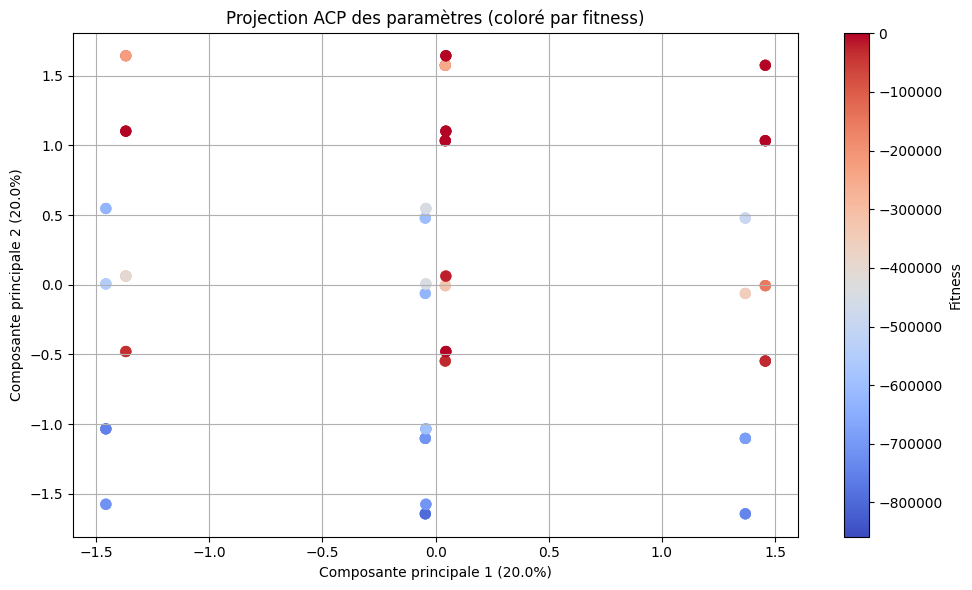

In [123]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Charger les données
df = pd.read_csv("pi-12-100-1000-001_results.csv")
X = df.drop(columns=["run_index", "best_fitness", "time_sec"])
fitness = df["best_fitness"]

# Standardiser
X_scaled = StandardScaler().fit_transform(X)

# Appliquer ACP
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

# Calcul de la variance expliquée
explained_var = pca.explained_variance_ratio_
print(f"Variance expliquée par PC1 : {explained_var[0]:.2%}")
print(f"Variance expliquée par PC2 : {explained_var[1]:.2%}")

# Noms des variables originales
features = X.columns.tolist()

# Composantes principales : poids des variables dans chaque axe
loadings = pca.components_

# Affichage propre
print("\n--- Contribution des variables à chaque composante ---")
for i, pc in enumerate(loadings):
    print(f"\nPC{i+1} ({explained_var[i]*100:.1f}% de variance) :")
    for feature, coef in zip(features, pc):
        print(f"  {feature:15} => {coef:.3f}")



plt.figure(figsize=(10, 6))
scatter = plt.scatter(components[:, 0], components[:, 1], c=fitness, cmap="coolwarm", s=50)

plt.title("Projection ACP des paramètres (coloré par fitness)")
plt.xlabel(f"Composante principale 1 ({explained_var[0]*100:.1f}%)")
plt.ylabel(f"Composante principale 2 ({explained_var[1]*100:.1f}%)")
plt.colorbar(scatter, label="Fitness")
plt.grid(True)
plt.tight_layout()
plt.show()

